### Introduction

**Data-driven models** offer valuable advantages in modeling fermentation processes. When large datasets of sensor readings are available, these models capture complex nonlinear relationships and dynamics that traditional mechanistic models may miss due to lack of flexibility. Data-driven models, on the other hand, adapt to changing conditions, which matches the dynamic nature of fermentations and results in accurate calculations. They are particularly effective when mechanistic understanding is limited or process interactions are unclear. However, they require extensive data with sufficient variation for robustness, and their interpretability may be compromised compared to mechanistic models.

**Random Forest** is a machine learning algorithm that combines multiple decision trees to improve prediction accuracy and reduce overfitting. It works by creating many different decision trees during training, each using only a subset of the data and features. The results of each tree are then combined, often by voting or averaging, to create the final prediction.  Random forest's ability to capture non-linearities and complex interactions is well suited to fermentation data, while its robustness to overfitting and resistance to outliers provides reliable predictions even in the presence of noisy sensor readings.

### Structure

- Import of the dataset (500 batches)
- Checking for NaNs
- Normalization (the objective function of the ML model converges faster when all features are of the same scale)
- Splitting the data into training and test datasets
- Defining the model
    - n_estimators = 10 (number of trees created in the forest)
    - min_samples_leaf = 15 (minimum number of samples required to be at a leaf node)
- Training the model
- Testing the model
- Feature Importance

### Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from F_model import show_plot_qs

pd.options.mode.chained_assignment = None  # Suppress the warning

**Import & Preprocessing of the data**

In [2]:
# Load data
df = pd.read_csv('data/batch_no1/generated data/df_gen.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
# Check for NaN because ML model can't handle them
df['qs'].fillna(method='ffill', inplace=True)
df['qs'][0] = df['qs'][1]
df['batch_id'] = df['batch_id'].astype(str).str.zfill(3)

In [4]:
# check of all NaN are removed
df.isna().sum()

time        0
biomass     0
glucose     0
batch_id    0
qs          0
dtype: int64

**Normalization of the dataset**

In [5]:
df_norm = df.drop(['time', 'batch_id'], axis=1).copy()
mean = df_norm.mean()
std = df_norm.std()
df_norm = (df_norm - mean) / std
df_norm['time'] = df['time']
df_norm['batch_id'] = df['batch_id']

<Axes: xlabel='time', ylabel='biomass'>

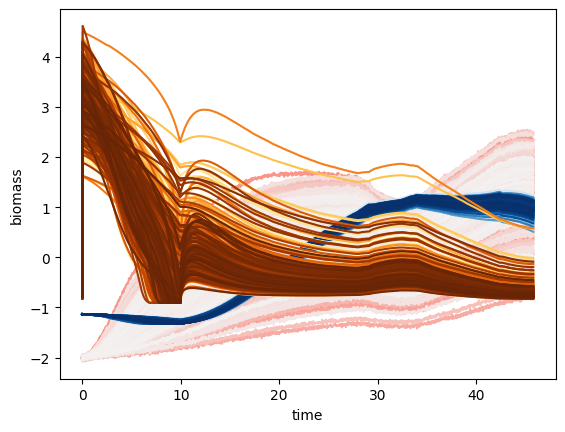

In [6]:
sns.lineplot(data=df_norm, x='time', y='biomass', hue='batch_id', palette='light:salmon_r', legend=False)
sns.lineplot(data=df_norm, x='time', y='glucose', hue='batch_id', palette='Blues', legend=False)
sns.lineplot(data=df_norm, x='time', y='qs', hue='batch_id', palette='YlOrBr', legend=False)

**Splitting the dataset in training and test data**

In [7]:
# group the df by batch_id and take the maximum value of qs
## output is an array (shape: [500,2]) which contains all unique batch_ids and a corresponding max qs
# based on the mean value of the array a binary col is created
## when splitting the data in train & test it is ensured that high and low values of qs are equally distributed
df_grouped = df_norm.groupby('batch_id')['qs'].max().reset_index()
mean_qs = df_grouped['qs'].mean()
df_grouped['bin'] = df_grouped['qs'].apply(lambda x: 1 if x > mean_qs else 0)

In [8]:
# Split in the list of unique batch_ids into train and test
## I take the batch_ids instead of the whole dataset because otherwise snippets of one batch can be in both train and test set
## result is better because it has not already seen the data
b_train, b_test = train_test_split(df_grouped, test_size=0.2, stratify=df_grouped['bin'], random_state=42)

In [9]:
# check how many 1 and 0 are in each group
print(np.unique(b_train['bin'], return_counts=True))
print(np.unique(b_test['bin'], return_counts=True))

(array([0, 1], dtype=int64), array([201, 199], dtype=int64))
(array([0, 1], dtype=int64), array([50, 50], dtype=int64))


In [10]:
b_train = list(b_train['batch_id'].values)
b_test = list(b_test['batch_id'].values)

In [11]:
df_train = df[df['batch_id'].isin(b_train)]
df_test = df[df['batch_id'].isin(b_test)]

In [12]:
# Define X and y
X_train = df_train.copy().drop(['qs'], axis=1)
y_train = df_train['qs'].values

X_test = df_test.copy().drop(['qs'], axis=1)
y_test = df_test['qs'].values

**Define the model, train & test the model**

In [13]:
model = RandomForestRegressor(n_estimators=10, min_samples_leaf=15 ,random_state=42)
model.fit(X_train, y_train)

# Step 4: Make predictions on the testing data
y_pred = model.predict(X_test)

# Step 5: Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0014960316461343427


**Feature Importance**

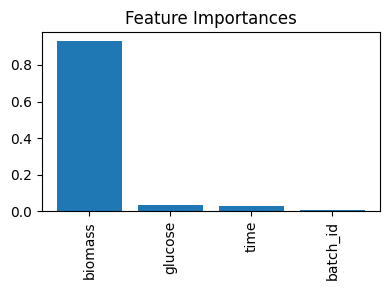

In [14]:
# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order

# Plot feature importances
plt.figure(figsize=(4, 3))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

**Data Visualization of one batch**

In [15]:
df_test_result = pd.DataFrame(X_test, columns=X_test.columns)
df_test_result['qs'] = y_test
df_test_result['qs_predicted'] = y_pred

print(b_test[:10])

['185', '230', '208', '292', '384', '431', '277', '300', '094', '165']


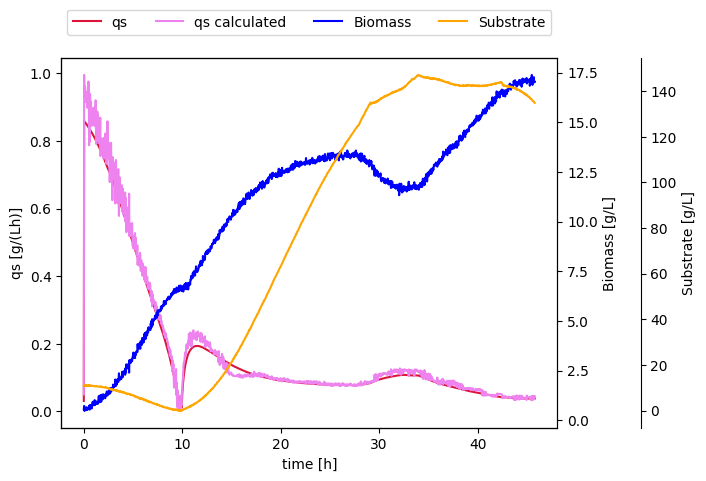

In [17]:
df_one = df_test_result[df_test_result['batch_id'] == '300']
show_plot_qs(df_one)